<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

Tensorflow version: 2.1.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


### Task 3: Retrieve Sentences and Corresponsing Tags

### Task 4: Define Mappings between Sentences and Tags

### Task 5: Padding Input Sentences and Creating Train/Test Splits

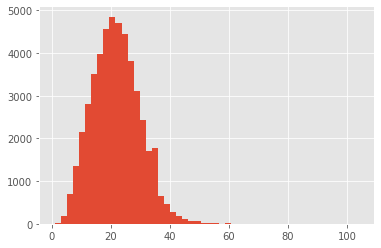

### Task 6: Build and Compile a Bidirectional LSTM Model

### Task 7: Train the Model

### Task 8: Evaluate Named Entity Recognition Model

9592/9592 [==============================] - 12s 1ms/sample - loss: 0.0484 - accuracy: 0.9856


[0.04835232572507321, 0.9855588]